In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [3]:
fakeData= "/Users/nourramadan/Documents/Fake.csv"
trueData="/Users/nourramadan/Documents/True.csv"
df_fake=pd.read_csv(fakeData)
df_real=pd.read_csv(trueData)


In [4]:
#print first few rows of fake news data
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
#print first few rows of real news data
df_real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
print(df_fake.shape) # output number of rows and columns
print(df_real.shape) # output number of rows and columns

(23481, 4)
(21417, 4)


In [7]:
import pandas as pd
# balance the dataset
df_fake_sampled= df_fake.sample(n=len(df_real), random_state=42)
df_fake= df_fake_sampled.head(len(df_real)).copy()

print("Shape of df_fake : ", df_fake.shape)
print("Shape of df_real : ", df_real.shape)

Shape of df_fake :  (21417, 4)
Shape of df_real :  (21417, 4)


In [8]:
print(df_fake['subject'].value_counts()) # display counts of each subject

News               8241
politics           6259
left-news          4074
Government News    1433
US_News             708
Middle-east         702
Name: subject, dtype: int64


In [9]:
print(df_real['subject'].value_counts()) # display counts of each subject

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64


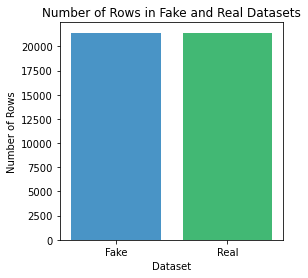

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the shapes of the datasets
fake_shape = df_fake.shape[0]
real_shape = df_real.shape[0]

# Choose colors
colors = ["#3498db", "#2ecc71"] 

# Create a bar plot
plt.figure(figsize=(4, 4))
sns.barplot(x=['Fake', 'Real'], y=[fake_shape, real_shape], palette=colors)
plt.title('Number of Rows in Fake and Real Datasets')
plt.xlabel('Dataset')
plt.ylabel('Number of Rows')
plt.show()


In [11]:
df_fake = df_fake.drop('date', axis=1) # drop date column

In [12]:
df_real = df_real.drop('date', axis=1) # drop date column

In [13]:
# add label and assign for each data before merging
df_fake['label'] ='Fake'
df_real['label'] ='True'


In [14]:
import pandas as pd
# merge datasets
df_merged = pd.concat([df_fake, df_real], ignore_index=True)
df_merged.head()

,title,text,subject,label
0,ABOUT HILLARY’S COUGH: We Discovered The Secre...,,politics,Fake
1,BREAKING: OBAMACARE REPEAL Clears First Hurdle...,The Senate voted 51-48 this afternoon to proce...,politics,Fake
2,‘SLEEPY’ JUSTICE GINSBURG: Excites Crowd By Sa...,So much for the SCOTUS not being political Che...,left-news,Fake
3,WATCH: Kellyanne Conway Very Upset Hillary Cl...,White House counselor Kellyanne Conway crawled...,News,Fake
4,"GOP Gives Trump The Middle Finger, Prepares T...",Donald Trump may have decided that Russia is g...,News,Fake


Average Title Length by Classification:
label
Fake    94.184199
True    64.667881
Name: title_length, dtype: float64


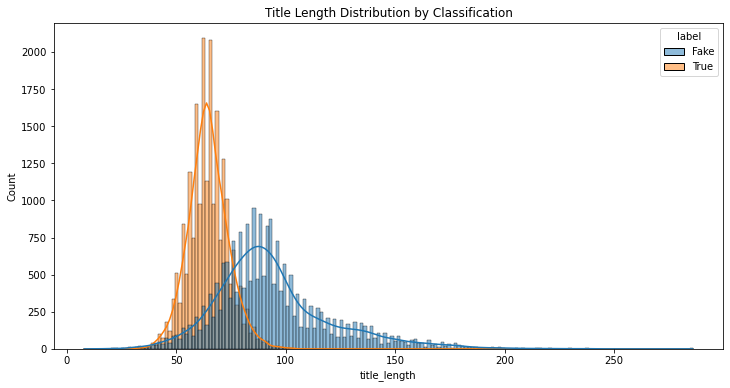

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for title length
df_merged['title_length'] = df_merged['title'].apply(len)

# Calculate the average title length for each class
average_title_length = df_merged.groupby('label')['title_length'].mean()

# Display result
print("Average Title Length by Classification:")
print(average_title_length)

# Plotting histogram
plt.figure(figsize=(12, 6))
sns.histplot(x='title_length', hue='label', data=df_merged, kde=True)
plt.title('Title Length Distribution by Classification')
plt.show()

In [16]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


def preprocess_text(text):
    # Lowercasing
    text = text.lower()
   
    # Tokenization
    tokens = word_tokenize(text)
   
    # Removing stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in string.punctuation]
   
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
   
    return tokens

# Apply text preprocessing and create a list of words for each label
fake_words = df_merged[df_merged['label'] == 'Fake']['text'].apply(preprocess_text)
true_words = df_merged[df_merged['label'] == 'True']['text'].apply(preprocess_text)

# Flatten the lists of words
fake_word_list = [word for sublist in fake_words for word in sublist]
true_word_list = [word for sublist in true_words for word in sublist]

# Count the occurrences of each word
fake_word_counts = Counter(fake_word_list)
true_word_counts = Counter(true_word_list)

# Display the most common words for each label
print("Most Common Words for 'Fake' Label:")
print(fake_word_counts.most_common(10))

print("\nMost Common Words for 'True' Label:")
print(true_word_counts.most_common(10))


df_merged['processed_text'] = df_merged['text'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nourramadan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nourramadan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nourramadan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most Common Words for 'Fake' Label:
[('trump', 67816), ('said', 28421), ('president', 24002), ('people', 23790), ('one', 21675), ('would', 21292), ('state', 20052), ('clinton', 16984), ('like', 16516), ('time', 16329)]

Most Common Words for 'True' Label:
[('said', 99037), ('trump', 54280), ('state', 36243), ('would', 31526), ('reuters', 28412), ('president', 26939), ('republican', 22098), ('government', 19433), ('year', 18721), ('house', 16906)]


In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from collections import Counter

In [19]:
fake_data_path = "/Users/nourramadan/Documents/Fake.csv"
true_data_path = "/Users/nourramadan/Documents/True.csv"
df_fake = pd.read_csv(fake_data_path)
df_true = pd.read_csv(true_data_path)

In [20]:
df_fake['label'] = 'Fake'
df_true['label'] = 'True'
df_merged = pd.concat([df_fake, df_true], ignore_index=True)

# Tokenize and preprocess text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words and word not in string.punctuation]
    return tokens

df_merged['processed_text'] = df_merged['text'].apply(preprocess_text)

In [21]:
# train and test the data with 80/20 split
train_data, test_data = train_test_split(df_merged, test_size=0.2, random_state=42)

In [22]:
all_tokens = [word for sublist in train_data['processed_text'] for word in sublist]
vocab_size = 10000
word_counts = Counter(all_tokens)
vocab = [word for word, _ in word_counts.most_common(vocab_size)]

In [23]:
# Convert words to indices in the vocabulary
word_to_index = {word: idx for idx, word in enumerate(vocab)}
train_data['indexed_text'] = train_data['processed_text'].apply(lambda x: [word_to_index[word] for word in x if word in word_to_index])
test_data['indexed_text'] = test_data['processed_text'].apply(lambda x: [word_to_index[word] for word in x if word in word_to_index])

In [24]:
max_seq_length = 200
train_data['padded_text'] = train_data['indexed_text'].apply(lambda x: x[:max_seq_length] + [0] * (max_seq_length - len(x)))
test_data['padded_text'] = test_data['indexed_text'].apply(lambda x: x[:max_seq_length] + [0] * (max_seq_length - len(x)))

In [25]:
# Convert the 'padded_text' column of the training data to a tensor
X_train = torch.tensor(train_data['padded_text'].tolist())
# Convert the 'label' column of the training data to a tensor,
# mapping 'Fake' to 0 and 'True' to 1 for binary classification
y_train = torch.tensor(train_data['label'].map({'Fake': 0, 'True': 1}).tolist()

X_test = torch.tensor(test_data['padded_text'].tolist())
y_test = torch.tensor(test_data['label'].map({'Fake': 0, 'True': 1}).tolist())

In [26]:
# Set the batch size for loading the data
batch_size = 32
# Create a TensorDataset for the training set using input features and labels
train_dataset = TensorDataset(X_train, y_train)
# Create a DataLoader for the training set to enable batching and shuffling of the data

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# Attention model with LSTM network
class AttentionModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(AttentionModel, self).__init__()
        # Embedding layer that converts word indices into dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Embedding layer that converts word indices into dense vectors
        self.attention = nn.MultiheadAttention(embed_size, num_heads=1)
        # LSTM layer to capture sequential dependencies in the input data
        self.rnn = nn.LSTM(embed_size, hidden_size, batch_first=True)
        # Fully connected layer to produce final class scores
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Pass the input word indices through the embedding layer
        embedded = self.embedding(x)
        # Apply the attention mechanism to the embedded inputs
        
        attention_output, _ = self.attention(embedded.permute(1, 0, 2), embedded.permute(1, 0, 2), embedded.permute(1, 0, 2))
        attended_embedding = attention_output.permute(1, 0, 2)
        # Feed the attended embeddings into the LSTM network
        rnn_output, _ = self.rnn(attended_embedding)
        # Take the last hidden state of the LSTM for classification
        output = self.fc(rnn_output[:, -1, :])
        return output

In [32]:
vocab_size = len(vocab)
embed_size = 100
hidden_size = 64
output_size = 2

model = AttentionModel(vocab_size, embed_size, hidden_size, output_size)
# Define the loss function for classification
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
import time

num_epochs = 5 # set num of epochs
for epoch in range(num_epochs):
    start_time = time.time()

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch + 1}/{num_epochs}, Time: {epoch_time:.2f} seconds")

Epoch 1/5, Time: 207.99 seconds
Epoch 2/5, Time: 208.32 seconds
Epoch 3/5, Time: 206.49 seconds
Epoch 4/5, Time: 207.35 seconds
Epoch 5/5, Time: 206.50 seconds


In [35]:

model.eval()
# Initialize lists to store all predictions and true labels
all_predictions = []
all_labels = []
with torch.no_grad():
    # Loop over the test dataset
    for inputs, labels in test_loader:
        outputs = model(inputs)
        # Get predicted class by taking the argmax of the output probabilities
        predictions = torch.argmax(outputs, dim=1)
        # store predictions and labels in lists
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [36]:
# display accuracy, precision, recall, f1 score, and confusion matrix

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9947
Precision: 0.9955
Recall: 0.9932
F1 Score: 0.9943
Confusion Matrix:
[[4714   19]
 [  29 4218]]


In [38]:
from sklearn.metrics import classification_report

# Evaluate on the test set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print the classification report
class_names = ['Fake', 'True']
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99      4733
        True       1.00      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [39]:
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Example text
new_text = "Scientists discover a new planet in our solar system."

# Preprocess the new text
def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in string.punctuation]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

processed_text = preprocess_text(new_text)

# Convert words to indices using the same word_to_index mapping
indexed_text = [word_to_index[word] for word in processed_text if word in word_to_index]

# Pad the sequence
max_seq_length = 200
padded_text = indexed_text[:max_seq_length] + [0] * (max_seq_length - len(indexed_text))

# Convert to PyTorch tensor
input_tensor = torch.tensor([padded_text])

# Make prediction
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output).item()

# Map predicted class index to label
predicted_label = 'Fake' if predicted_class == 0 else 'True'

print(f"Predicted Label: {predicted_label}")

Predicted Label: Fake


Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99      4733
        True       1.00      0.99      0.99      4247

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



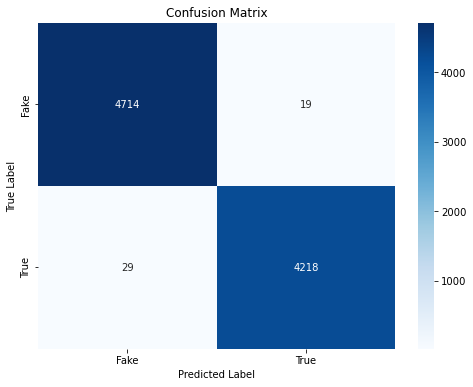

In [41]:
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and print the classification report
class_names = ['Fake', 'True']
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Calculate and plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()